# Lab Assignment One: Exploring Table or Text Data
### by Ryan Cole, Michael Han, Andrew Kozelsky, and Vince Miller

#  Business Understanding

The document dataset is retrieved from the National Transportation Safety Board (NTSB) aviation accident database. The database contains investigations about civil aviation accidents domestically or US aircraft internationally. The investigations are completed to prevent events from occuring in the future. Records are created by the NTSB's "Go Team", who are individuals that investigate into events. Investigators are assigned on a 24 hour rotational schedule and are those who complete the investigations. The first stage of an investigation is a preliminary report.

Each record contains a **'Preliminary'** report that created is created within 5 working days of the event. The preliminary report does not correspond with category classification for the event i.e. the category (orgnizational, personel, enviromental, aircraft, not determined, missing) for the event is not populated when the preliminary report is submitted.  Additional reports are created for up to 5 years. The average investigation is 2-3 years. The new reports do not alter the prelimiary report. When additional reports are created they correspond with a category for the event. 

The goal of this project is to use the prelimimary report to predict the eventual category or categories for the event. The National Transportation Safety Board could use classification from prelimiary reports to ready investigation teams, quickly notify stakeholders, or provide insight to the ability of the preliminary report to match eventual findings e.g. add additonal required items to the preliminary report.

After data cleaning, there are 35,000 records and nearly 30 million words in this data set.

Sources: 
* https://www.asias.faa.gov/apex/f?p=100:9:::NO::P9_REGION_VAR:2
* https://ntsb.gov/investigations/process/Pages/default.aspx

#  Data Encoding

In [1]:
import pandas as pd  
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pyodbc
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 


plt.rcParams['figure.figsize'] = [10,6]

In [2]:
# simple tic/toc functionality.  No error checking.
import time

class tictoc() :
    def __init__(self):
        self.start = None
        self.stop = None
    
    def tic(self):
        self.start = time.time()
        print('started timing')
    
    
    def toc(self):
        self.stop = time.time()
        print('stopped timing after ' + str(round((self.stop-self.start), 2)) + 'secs')
    
mytiming=tictoc()

### Read Document Data

The data is made available online at https://app.ntsb.gov/avdata/Access/, in the form of an Access database file.  We query the Access database file using an ODBC driver, and save the result in a parquet file.

In [3]:
# importing the dataset retrived from NTSB into python, using ODBC driver
# for windows environment build tools from https://visualstudio.microsoft.com/visual-cpp-build-tools/
import pyodbc

db_path =r'C:\Machine-Learning-Group\avall.mdb'

# specify connector
connection_string =  r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};' + 'DBQ={};'.format(db_path)
conn_str = (
    connection_string
    )
# create connection
cnxn = pyodbc.connect(conn_str)

# specify query
# note that access is dumb and requires fully specify table.feature names
rep_sql = """
SELECT t2.*, events.ev_date, events.ev_country, events.ev_state 
FROM
    (SELECT t1.*, 
                Findings.finding_no, Findings.finding_code, Findings.category_no, Findings.subcategory_no, 
                Findings.section_no, Findings.subsection_no, Findings.cause_factor, Findings.lchg_date, 
                Findings.lchg_userid 
    FROM
        (SELECT aircraft.ev_id, aircraft.Aircraft_Key, narratives.narr_accp
        FROM aircraft
        LEFT JOIN narratives
        ON aircraft.ev_id = narratives.ev_id 
            AND aircraft.Aircraft_Key = narratives.Aircraft_Key) as t1
    LEFT JOIN Findings
        ON t1.ev_id = Findings.ev_id 
            AND t1.Aircraft_Key = Findings.Aircraft_Key) as t2
LEFT JOIN events
ON t2.ev_id = events.ev_id
"""

# run query
df = pd.read_sql(rep_sql, cnxn)
df['ev_year'] = df.ev_date.dt.year

# Save intermediate file
df.to_parquet('avall.parquet')

In [4]:
# Read from parquet
raw_df = pd.read_parquet('avall.parquet')

print(raw_df.dtypes)

ev_id                     object
Aircraft_Key               int64
narr_accp                 object
finding_no               float64
finding_code              object
category_no               object
subcategory_no            object
section_no                object
subsection_no             object
cause_factor              object
lchg_date         datetime64[ns]
lchg_userid               object
ev_date           datetime64[ns]
ev_country                object
ev_state                  object
ev_year                    int64
dtype: object


### Verify data quality

##### Minimum Year Cutoff Selection

We exclude 7 outliers prior to 1982 that are possibly typos.  Compare to 3500+ records in 1982.

In [5]:
print(raw_df[raw_df.ev_year < 1982].ev_date)
print(str(len(raw_df[raw_df.ev_year == 1982])) + ' records in 1982')
df = raw_df[raw_df.ev_year >= 1982]

45889    1948-10-24
45891    1981-08-01
45892    1962-07-19
45893    1977-06-19
57625    1979-08-02
61400    1974-08-30
105468   1979-09-17
Name: ev_date, dtype: datetime64[ns]
3593 records in 1982


At first glance we observe spike in number of records annually starting in 2008, but this is due to how data is structured in the database.

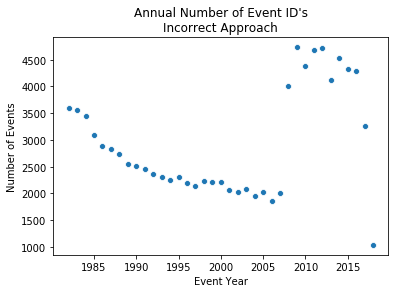

In [6]:
gdf = df.groupby(['ev_year'])['ev_id'].agg(['count']).reset_index()
g1 = sns.scatterplot(x = 'ev_year', y='count', data=gdf)
g1.set_title("Annual Number of Event ID's\nIncorrect Approach")
g1.set_xlabel('Event Year')
g1.set_ylabel('Number of Events')
plt.show()

Prior to 2008, event IDs are unique.  Starting in 2008 event findings are mapped to codes/categories, and there can be multiple findings per event.

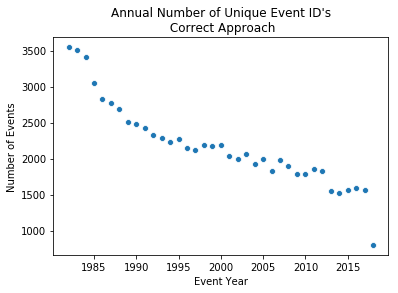

In [7]:
gdf = df.groupby(['ev_year'])['ev_id'].agg(['nunique']).reset_index()
g1 = sns.scatterplot(x = 'ev_year', y='nunique', data=gdf)
g1.set_title("Annual Number of Unique Event ID's\n Correct Approach")
g1.set_xlabel('Event Year')
g1.set_ylabel('Number of Events')
plt.show()

We are interested in mapping preliminary text to event codes, so we discard records dated prior to 2008.

In [8]:
df = df[df.ev_year >= 2008]

##### Check for Non-Ascii characters

Given that we are operating on texts from unknown data source, we would like to know if we have many unusual characters in the narrative texts.  The following class counts the occurence of all ascii letters, digits, punctuation, and whitespace, as well as characters that do not fit any of these classifications.

In [9]:
# letter counts for each narrative column (hash all letters in all words)
import string

#will hash space, alphanumeric, punctuation and whitespace, and exclude as desired
allowed_chars_string = string.ascii_letters + string.digits + string.punctuation + string.whitespace
allowed_chars = [char for char in allowed_chars_string]

# class to count every occurence of every char every string in a column of a dataframe.  Limited/no error checking
class char_counts():
    def __init__(self, allowed_chars):
        self.char_counts = {char:0 for char in allowed_chars}
        self.other_count = 0
        self.letter_cnt = None
        self.number_cnt = None
        self.punct_cnt = None
        self.space_cnt = None
        self.other_whitespace = None
    def __str__(self):
        cnts = [self.other_count, self.letter_cnt, self.number_cnt, self.punct_cnt, self.space_cnt, self.other_whitespace]
        labels = ['other count', 'letter count', 'number count', 'punctuation count', 'space count', 'other whitespace count']
        n = sum(cnts)
        out = '\nNumber of times classes of letters occur (Percent occurence)'
        for i in range(len(cnts)):
            out = out + '\n' + labels[i] + ':   ' + str(cnts[i]) + '  (' + str(round(100 * cnts[i]/n,2)) + '%)'
        return out

    # either increment count for a char or increment other_count
    def char_hash(self, char):
        try:
            self.char_counts[char] = self.char_counts[char] + 1
        except:
            self.other_count = self.other_count + 1
    # hash every char in each string in each row of column
    def hash_column(self, df, col_name):
        for i in range(len(df)):
            mystr = df.iloc[i][col_name]
            # could be None
            if isinstance(mystr, str):
                for char in mystr:
                    self.char_hash(char)
    # return dataframe containing column for chars and column for counts of occurences
    def to_df(self):
        return pd.DataFrame(list(self.char_counts.items()), columns=['char', 'cnt'])
    # populate attributes for aggregate counts for alpha, numeric, punctuation, and whitespace
    def agg_stats(self):
        self.letter_cnt = 0
        for char in [x for x in string.ascii_letters]:
            self.letter_cnt = self.letter_cnt + self.char_counts[char]
        self.number_cnt = 0
        for char in [x for x in string.digits]:
            self.number_cnt = self.number_cnt + self.char_counts[char]
        self.punct_cnt = 0
        for char in [x for x in string.punctuation]:
            self.punct_cnt = self.punct_cnt + self.char_counts[char]
        self.space_cnt = self.char_counts[' ']
        self.other_whitespace = 0
        # whitespace not included space char
        whitespace_chars = [x for x in string.whitespace]
        whitespace_chars.remove(' ')
        for char in whitespace_chars :
            self.other_whitespace = self.other_whitespace + self.char_counts[char]

Using this code we scan the data and observe that a very small number of characters are not in the allowed characters.  We therefore proceed without concern about incorrect encoding or corrupted data.

In [10]:
mytiming.tic()
# create object to store results
prelim_counts = char_counts(allowed_chars)

# count every occurence of every char for each column
prelim_counts.hash_column(df, 'narr_accp')
prelim_counts.agg_stats()
mytiming.toc()
print(prelim_counts)
prelim_counts_df = prelim_counts.to_df()

started timing
stopped timing after 145.92secs

Number of times classes of letters occur (Percent occurence)
other count:   114383  (0.05%)
letter count:   168931632  (78.51%)
number count:   4373865  (2.03%)
punctuation count:   5408131  (2.51%)
space count:   34044485  (15.82%)
other whitespace count:   2313258  (1.08%)


Although there are many narrative accounts in the original dataset that are empty strings rather than null values, there are none in the time frame we have selected.

##### Check for Empty Strings

Although many records prior to 2008 have empty strings instead of null values for the narrative, this issue does not occur after 2008.

In [11]:
# Check for empty string instead of missing
len(df[df.narr_accp == ''])

0

#### Missing Values for Preliminary Report

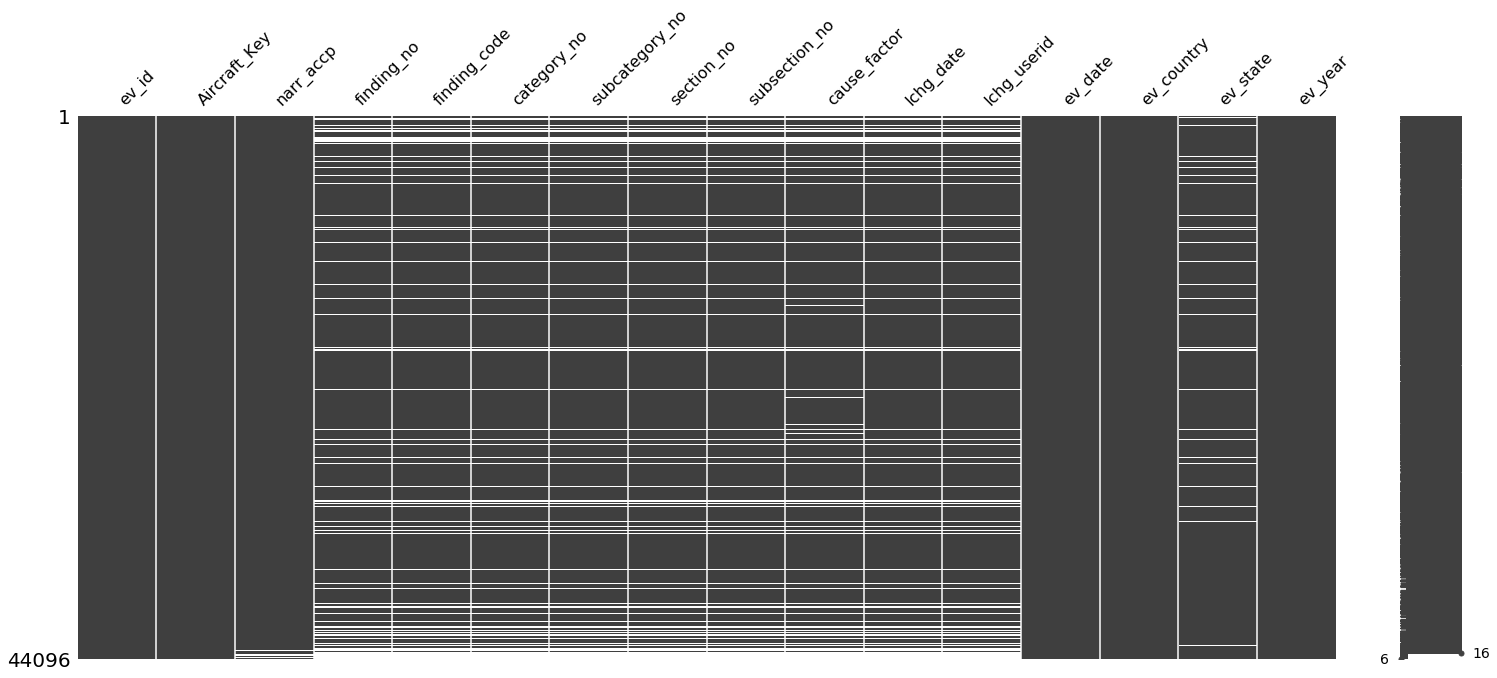

In [12]:
# visualize missing values
import missingno as msno

msno.matrix(df)

Above plot shows there are few missing values for preliminary narratives (narr_accp), and that missing values for features related to findings usually occur in bands.  This is likely because these entries are entered together when the finding information is input into the system.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44096 entries, 63696 to 108011
Data columns (total 16 columns):
ev_id             44096 non-null object
Aircraft_Key      44096 non-null int64
narr_accp         43869 non-null object
finding_no        39375 non-null float64
finding_code      39375 non-null object
category_no       39375 non-null object
subcategory_no    39375 non-null object
section_no        39375 non-null object
subsection_no     39375 non-null object
cause_factor      39086 non-null object
lchg_date         39375 non-null datetime64[ns]
lchg_userid       39375 non-null object
ev_date           44096 non-null datetime64[ns]
ev_country        44096 non-null object
ev_state          42300 non-null object
ev_year           44096 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(2), object(11)
memory usage: 5.7+ MB


.info() function presents same information in text format.

Missing preliminary narratives occur with greater frequency in more recent data with <1% annually missing preliminary text. We will discard events without preliminary reports. We believe the dataset is large enough to overcome the data loss. Also, we are less interested in the few events without preliminary reports as compared to classifying the majority into category number.

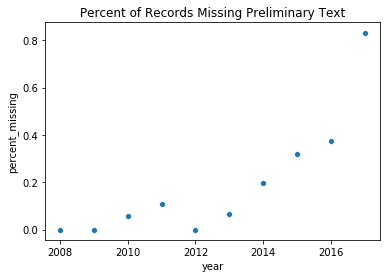

In [14]:
# group by ignores missing, use this instead of filling missing values
yearly_data = [[yr,  
                100 * len(df[(df.narr_accp.isnull()) & (df.ev_date.dt.year == yr)]) \
                / len(df[df.ev_date.dt.year == yr].ev_id.unique())] for yr in range(2008,2018)]
yearly_df = pd.DataFrame.from_records(yearly_data, columns=['year', 'percent_missing'])
g2 = sns.scatterplot(x = 'year', y='percent_missing', data=yearly_df)
g2.set_title('Percent of Records Missing Preliminary Text')
plt.show()

Exclude records that do not have a preliminary narrative from our analysis.

In [15]:
df = df[df.narr_accp.isnull() == False]

#### Missing Values for Target Class

In [16]:
# creating keys 
df['month_year'] = df['ev_date'].map(lambda x: str(x.year) + '/' + str(x.month)).map(lambda x: pd.to_datetime(x, format='%Y/%m'))
df['ev_id_Aircraft_Key'] = df['ev_id'].apply(lambda x: str(x)) + df['Aircraft_Key'].apply(lambda x: str(x))
df['ev_id_Aircraft_Key_finding_no'] = df['ev_id_Aircraft_Key'].apply(lambda x: str(x)) + df['finding_no'].apply(lambda x: str(x))

# percent of target class missing
print(str(round(100 * (df['category_no'].isna().sum() / len(df['category_no'])),1)) + \
      '% of the target class are missing for observations 2008 and beyond')
# missing values in finding_no correspond to missing value in category_no
df[['Aircraft_Key','ev_id','finding_no','category_no','ev_id_Aircraft_Key_finding_no'
   ]][df['finding_no'].isna() | df['category_no'].isna()].head()

10.2% of the target class are missing for observations 2008 and beyond


Aircraft_Key           ev_id  finding_no category_no  \
63696             1  20080107X00026         NaN        None   
63697             2  20080107X00026         NaN        None   
63698             1  20080107X00027         NaN        None   
63710             1  20080111X00038         NaN        None   
63711             1  20080111X00039         NaN        None   

      ev_id_Aircraft_Key_finding_no  
63696            20080107X000261nan  
63697            20080107X000262nan  
63698            20080107X000271nan  
63710            20080111X000381nan  
63711            20080111X000391nan

Found while exploring the dataset, and previewed in the table above; Missing values in the target class correspond with missing values in the finding number (1,2,3,etc.) for the event. It is possible this finding is not complete or a 'finding' will not be found for this record. Later these missing values will be coded as 'Unknown'.

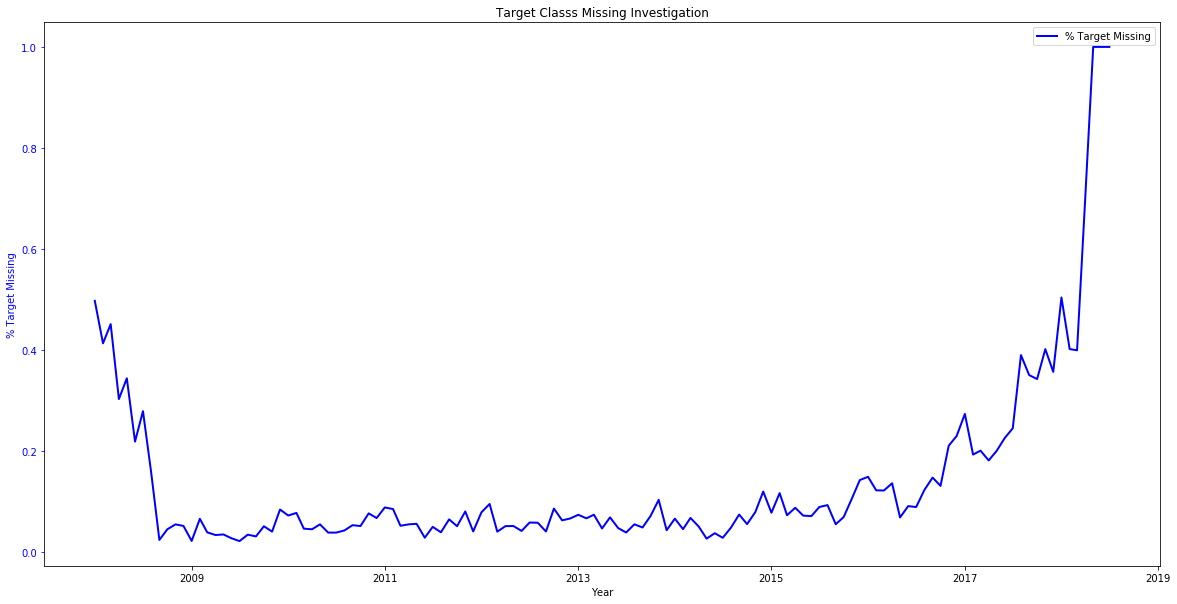

In [17]:
# further investigate missing in target class
df_missing_pct = df['category_no'].isnull().groupby(df['month_year']).sum() / df['category_no'].fillna(0).groupby(df['month_year']).count()

# create first plot for % missing
fig, ax1 = plt.subplots(figsize=(20,10))
t = df_missing_pct.index
s1 = df_missing_pct.values
ax1.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('% Target Missing', color='b')
ax1.tick_params('y', colors='b')


# add events to plot
#ax2 = ax1.twinx()
ax1 = ax1.plot(t, s1, 'b', linewidth=2, label='% Target Missing')
#s2 = df['category_no'].fillna(0).groupby(df['month_year']).count().values
#ax2.set_ylabel('Events', color='r')
#ax2.tick_params('y', colors='r')
#ax2 = ax2.plot(t, s2, 'r', linewidth=2, label='Events')

# adding legend for plot with multiple axes
lns = ax1 #+ ax2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

# add title
plt.title('Target Classs Missing Investigation')
plt.show()

We observe a higher missing percent before 2009 this corresponds with a potentially new proctocol we found earlier. We observean increase in missing percent in 2017 and 2018. Higher percentage missing in recent years could indicate that the investigation is still ongoing.

We are assuming that missing variables are due to an ongoing investigation, or an investigation that will never be concluded.  After excluding recent years, we assume that investigations with missing values for finding classes will never be concluded.  There is a significant possible hazard in this assumption. The hazard is that missing category_no that will eventually be resolved (in the case of being over a year and a half old) are not similar to those that will never be resolved. We will investigate this hazard further when attempting to fit a model. As stated earlier we will code these missing target classes as 'Unknown'.

In [18]:
df = df[(df.ev_year >= 2009) & (df.ev_year <= 2016)]
print(len(df), ' records retained from data set')
df['word_count'] = df['narr_accp'].apply(lambda x: len(x.split()))
print(str(df.word_count.sum()) + ' words in retained data' )

35774  records retained from data set
29705768 words in retained data


We will restrict our analysis to 2009-2016.


In [19]:
# percent of target class missing
print(str(round(100 * (df['category_no'].isna().sum() / len(df['category_no'])),3)) + \
      '% of the target class are missing for observations in years 2009-2016')
print('The target variable contains ' + str(df['category_no'].isna().sum()) + ' missing values.')

6.365% of the target class are missing for observations in years 2009-2016
The target variable contains 2277 missing values.


The percent missing in the target class for the selected date range is shown above.

##### Choose a vocabulary

Given that our database is maintained by the National Transportation Safety Board we expect all the records to be in the english language.  We verify this programmatically using the langdetect package.

In [20]:
# This takes 10-15 minutes
# The following code detects the language of each entry in the 'narr_accp', and prints the number of non-English entries 
from langdetect import detect

#Check documents to see if they're in English
mytiming.tic()
df['Language'] = df['narr_accp'].apply(lambda x: detect(x))
print(len(df[df.Language != 'en']))
mytiming.toc()

started timing
0
stopped timing after 828.57secs


Note that the detect() function in langdetect is not deterministic.  It occasionally flags the following preliminary narrative as french instead of english.

"On August 16, 2015, an MX2 aerobatic airplane, N88MX, impacted terrain near Chateauneuf sur Cher airport (LFFU) France. The pilot parachuted from the airplane and received minor injuries.\r\n\r\nThe accident investigation is under the jurisdiction and control of the French government. This report is for information purposes only and contains only information released by or obtained from the French Bureau d'Enquêtes et d'Analyses (BEA) pour la sécurité de l'aviation civile.\r\nFurther information pertaining to this accident may be obtained from:\r\n\r\nBureau d'Enquêtes et d'Analyses pour la sécurité de l'aviation civile\r\nBtiment 153\r\n200 rue de Paris\r\nZone sud\r\nAéroport du Bourget\r\n93352 Le Bourget Cedex\r\nFrance\r\n\r\nWebsite:http://www.bea.aero"

In [21]:
# this prelim report uses a significant amount of french describing name and address of French entity
# will retain this record and drop non-english words
df[df.Language != 'en'].narr_accp

Series([], Name: narr_accp, dtype: object)

The above prelim report uses a significant amount of french describing name and address of French entity.  We will retain this record and drop non-english words by choosing english as our dictionary below.

##### Remove Words from the Vocabulary that are Not Relevant

Note that the work described as "remove words from the vocabulary that are not relevant or that you think should not be included" is done in the bag-of-words code below

### Bag-of-Words Representation
We convert the data from raw text into a sparse encoded bag-of-words representation. We eliminate English stop words from our representation.  We also eliminate words that occur in more than 75% of documents because it is unlikely that we will draw inferences from these very common words (treating as corpus specific stop words). The value of 75% was selected because the preliminary reports are very similar to one another many of the same words occur in each report. This was seen while viewing tf-idf for the words, the word frequencies, and the word clouds.  We choose to eliminate words that occur in less than 1% of documents, assuming they do not convey meaningful information.  This value is conservative because we did not want to remove words that could be potential in classifying the documents. Essentially, our inital hypothesis is that very nonfrequent words is our best chance at classifying. These parameters can be adjusted via the train test split. 


In [22]:
# create bag of words
from sklearn.feature_extraction.text import CountVectorizer

mytiming.tic()
count_vect = CountVectorizer(stop_words = 'english', min_df = .01, max_df = .75)
# not using regexpr to remove digits token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b'

text_list = df['narr_accp'].dropna().tolist()

# fit transform to get bag of words
bag_words = count_vect.fit_transform(text_list)
mytiming.toc()
# Puts bag of words into a pandas dataframe
count = pd.DataFrame(data = bag_words.toarray(), columns = count_vect.get_feature_names())

# 10 Words with highest count
print('\ntop 10\n', count.sum().sort_values(ascending=False)[:10])

# 10 words with lowest count
print('\nbottom 10\n', count.sum().sort_values()[:10])


started timing
stopped timing after 35.07secs

top 10
 engine      183836
accident    148963
fuel        117671
time        108871
feet        103160
left         95142
landing      88376
right        87926
runway       87391
airport      80668
dtype: int64

bottom 10
 simply           363
geostationary    363
slowing          374
1353             389
closely          389
raise            390
warned           395
hanging          395
autopsies        396
screened         397
dtype: int64


The word most frequent after using the max_df, min_df, and stop_words was engine. This word could be a good predictor of aircraft as the issue, and does not initially appear as if it would be an indicator of orginizational. The second word, accident, is more ambiguous as a predictor. This back and forth theme continues. We will more than likely need to tune our parameters.

For the bottom 10 each word that appears is an english word except 1353. These words could have meaning in classification. While it appears the bottom words could potentially have meaning in terms of classification the min_df more than likely will need to be tuned.

### TF-IDF Representation

TF-IDF is an abbreviation for term frequency–inverse document frequency https://en.wikipedia.org/wiki/Tf%E2%80%93idf.  Term frequency is a measure of how often a word occurs in all of the documents collectively, and inverse document frequency is a measure of how often a word occurs in a given document selected from the corpus.  TF-IDF is equal to the multiple of the term frequency and the inverse document frequency.

A high TF-IDF indicates that the word occurs frequently in a particular document but does not appear commonly across the collection of documents.  Words with low tf-idf occur frequency across all documents and/or occur infrequently within a given document.

Again, we eliminate words that occur in more than 75% of documents and less that 1% of documents. 

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

mytiming.tic()
# tf-idf vectorization
tfidf_vect = TfidfVectorizer(stop_words = 'english', token_pattern = '(?ui)\\b\\w*[a-z]+\\w*\\b', min_df = .01, max_df = .75)

# fit transform
tfidf_words = tfidf_vect.fit_transform(text_list)
mytiming.toc()
# shape and vocab
print('shape', tfidf_words.shape)

# tf-idf into dataframe
tfidf_df = pd.DataFrame(data = tfidf_words.toarray(), columns = tfidf_vect.get_feature_names())

# 10 words with highest and lowest tfidf score
print('\ntop 10\n', tfidf_df.max().sort_values(ascending=False)[:10])
print('\nlowest 10\n', tfidf_df.max().sort_values()[:10])

started timing
stopped timing after 50.99secs
shape (35774, 3227)

top 10
 rv            0.925090
balloon       0.911394
columbia      0.854984
glider        0.846721
cirrus        0.840354
el            0.836845
helicopter    0.836464
canopy        0.820367
slide         0.818138
hose          0.815799
dtype: float64

lowest 10
 organizational     0.050220
pathological       0.059843
screened           0.072145
bioaeronautical    0.072834
geostationary      0.074672
autopsies          0.076886
blunt              0.084199
served             0.086029
aeromedical        0.088660
example            0.088704
dtype: float64


Each document has its own TF-IDF scores for every word.  Above, we consider the maximum TF-IDF scores for each word across all documents.  The words with the highest and lowest maximum TF-IDF scores are listed above.  Words in the top 10 list occur more frequently in at least one document but do not occur in many documents, and words in the lowest 10 list occur less frequently even in the most frequent document and/or occur in many documents.

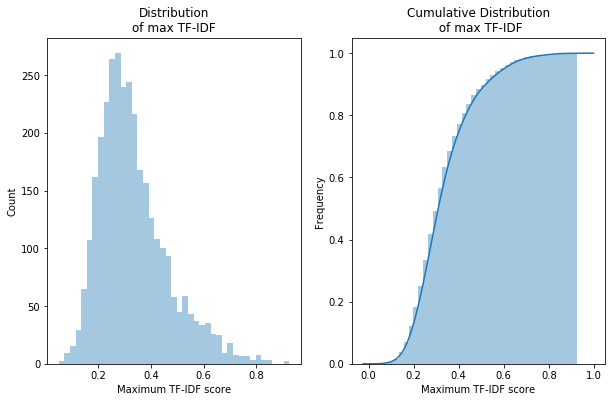

In [24]:
max_tfidfs = tfidf_df.max().reset_index()
max_tfidfs.columns = ['word', 'max_score']

my_axes = []
f, my_axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

g1 = sns.distplot(max_tfidfs.max_score, kde=False, ax=my_axes[0])
g2 = sns.distplot(max_tfidfs.max_score, kde=True, hist_kws={'cumulative': True}, kde_kws={'cumulative': True}, ax=my_axes[1])
g1.set_title("Distribution\nof max TF-IDF")
g1.set_xlabel('Maximum TF-IDF score')
g1.set_ylabel('Count')
g2.set_title("Cumulative Distribution\n of max TF-IDF")
g2.set_xlabel('Maximum TF-IDF score')
g2.set_ylabel('Frequency')
plt.show()

The distribution of maximum TF-IDF for each word across all documents shows that scores of 0.3 are common, and scores above 0.8 are relatively rare. The cumulative distribution indicates that scores above 0.6 occur less than 10% of the time in our data.

# Data Visualization

### Visualize statistical summaries

##### Events per Year and Month


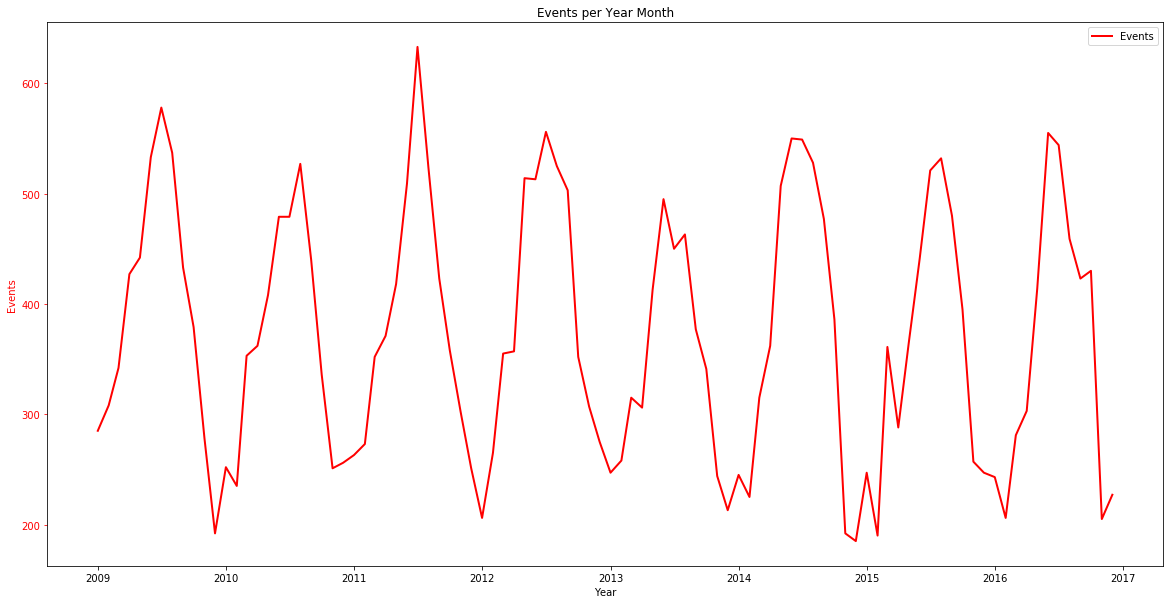

In [25]:
# further investigate missing in target class
df_missing_pct = df['category_no'].isnull().groupby(df['month_year']).sum() / df['category_no'].fillna(0).groupby(df['month_year']).count()

# create first plot for % missing
fig, ax2 = plt.subplots(figsize=(20,10))
t = df_missing_pct.index
#s1 = df_missing_pct.values
ax2.set_xlabel('Year')
# Make the y-axis label, ticks and tick labels match the line color.
#ax1.set_ylabel('% Target Missing', color='b')
#ax1.tick_params('y', colors='b')


# add events to plot
#ax2 = ax1.twinx()
#ax1 = ax1.plot(t, s1, 'b', linewidth=2, label='% Target Missing')
s2 = df['category_no'].fillna(0).groupby(df['month_year']).count().values
ax2.set_ylabel('Events', color='r')
ax2.tick_params('y', colors='r')
ax2 = ax2.plot(t, s2, 'r', linewidth=2, label='Events')

# adding legend for plot with multiple axes
lns = ax2
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc=0)

# add title
plt.title('Events per Year Month')
plt.show()

Seasonal trend is interesting to observe.  Possible due to more thunderstorms in summer, or less flying in winter. If the chart was created to only look at events per year we would see that amount of events occur normally.

##### Distribution of Findings per Event

There were 13478 events recorded in 2009 - 2016 involving 13685 different aircraft with 35774 different findings recorded.


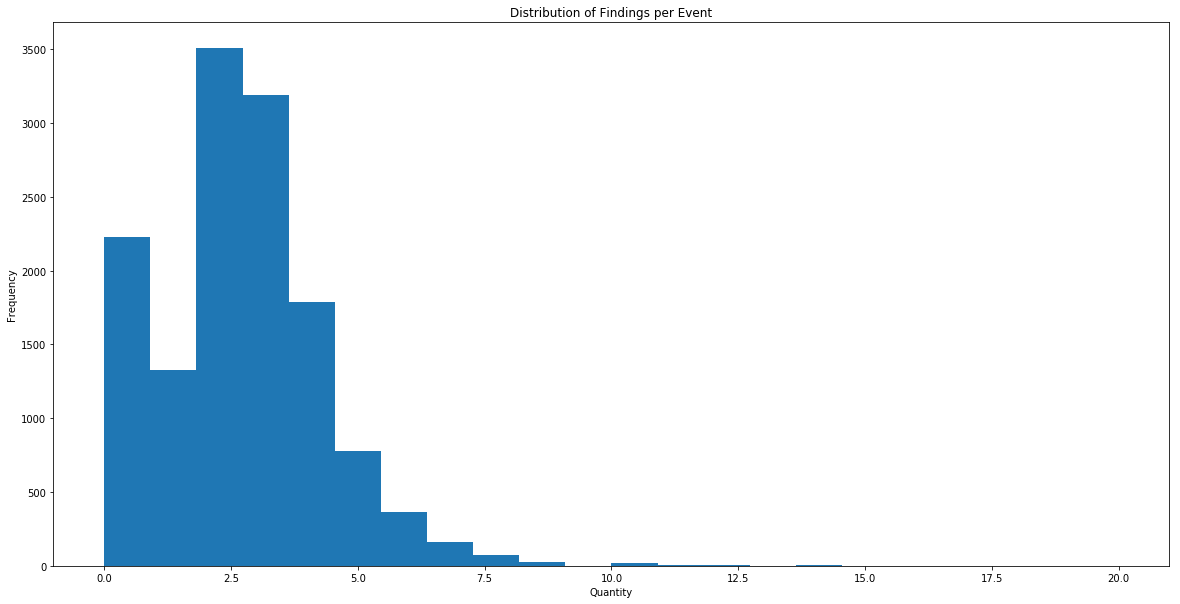

In [26]:
# amount of events
print('There were ' + str(len(df['ev_id'].unique())) + ' events recorded in 2009 - 2016 involving ' 
                    + str(len(df['ev_id_Aircraft_Key'].unique())) + ' different aircraft with '
                    + str(len(df['ev_id_Aircraft_Key_finding_no'].unique())) + ' different findings recorded.')
# amount of differnt findings
ax = df['category_no'].groupby(df['ev_id']).count().plot.hist(bins=22, figsize=(20,10))
ax.set_xlabel('Quantity')
plt.title('Distribution of Findings per Event')
plt.show()

The relative frequency of 0 findings is consistent with missing values.  Observe 2-3 findings as the most common per event.

###### Distribution of Categories

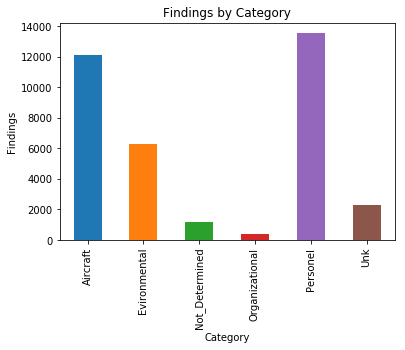

In [27]:
# converty category numbers to string values
dict_category = {'01': 'Aircraft', '02': 'Personel', '03': 'Evironmental', '04': 'Organizational', '05': 'Not_Determined', None: 'Unk'}
df['category_no'] = df['category_no'].map(dict_category)
# find most popular categories
ax = df['Aircraft_Key'].groupby(df['category_no']).count().plot.bar()
ax.set_xlabel('Category')
ax.set_ylabel('Findings')
plt.title('Findings by Category')
plt.show()

Personal and Aircraft are the most common categories attributed to an event, with Orginizational and Not Determined being relatively rare.

### Visualize Relevant Words and Word Frequencies

##### Vocabularies by Class
This plot displays the vocabulary size for each category of report in the data set. Stop words and other words that occur to little or too frequently are removed from the vocabulary.

['Aircraft', 'Personel', 'Evironmental', 'Organizational', 'Not_Determined', 'Unk']
[3363, 3664, 3282, 7699, 3581, 1214]


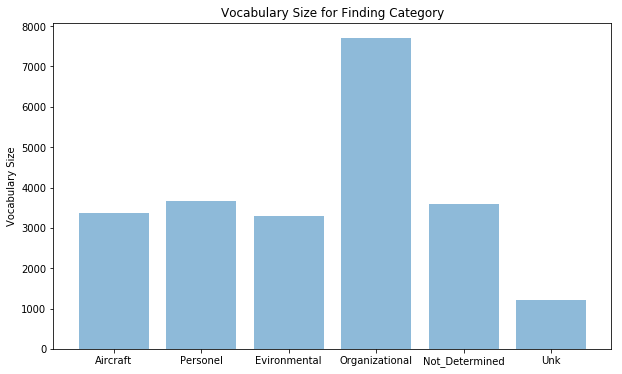

In [28]:
# create vocabulary sizes for each damage class, eliminating stop words
#plot vocab size for each damage class
vocab_lengths = list()
classes = list()
for cat in df['category_no'].unique():
    if cat != None:
        # create bag of words
        count_vect = CountVectorizer(max_df=.75,min_df=.01, stop_words='english')
        bag_words = count_vect.fit_transform(df['narr_accp'][df['category_no']==cat].dropna().tolist())
        # create pandas df of the words
        df_words = pd.DataFrame(data=bag_words.toarray(),columns=count_vect.get_feature_names())
        # create word cloud after reducing vocab
        vocab_lengths.append(len(count_vect.vocabulary_))
        classes.append(cat)

print(classes)
print(vocab_lengths)

plt.rcParams['figure.figsize'] = [10,6]
y_pos = np.arange(len(classes))
plt.bar(classes, vocab_lengths, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size for Finding Category')
plt.show()

Orginizational has the largest vocab. These issues must make for the most involved preliminary report.

##### Mean Report Length by Class

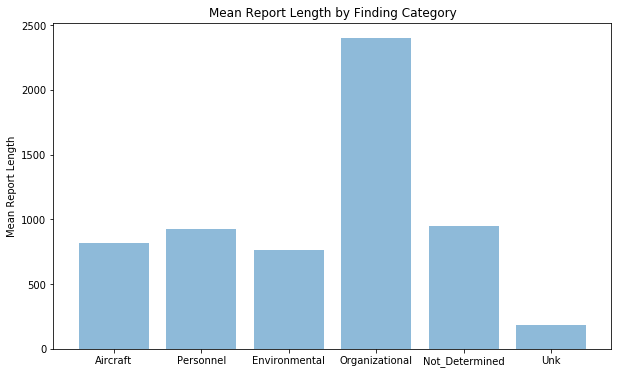

In [29]:
#Get empty list to store results
counts_list = list()
#Get list of number of words of each document in each class
for i in df.category_no.unique():
        indices = df[df['category_no']==i].index.tolist()
        counts_list.append(df.loc[indices]['narr_accp'].dropna().apply(lambda x: len(x.split())))

#Get empty list to store results
means_list = []

for i in counts_list:
    means_list.append(i.mean())

#Make plot of mean report length
plt.rcParams['figure.figsize'] = [10,6]
classes = ['Aircraft','Personnel','Environmental','Organizational','Not_Determined','Unk']
y_pos = np.arange(len(classes))
plt.bar(classes, means_list, align='center', alpha=0.5)
plt.xticks(y_pos, classes)
plt.ylabel('Mean Report Length')
plt.title('Mean Report Length by Finding Category')
plt.show()

Organization has the longest reports this is consistent with the vocab being the largest. Unknown has very short reports. These were the missing target class. It is possible that very little details were found and that is why the target is missing. This will make classifying the missing target class type events difficult.

#### The following histograms display the distributions of report lengths by class.

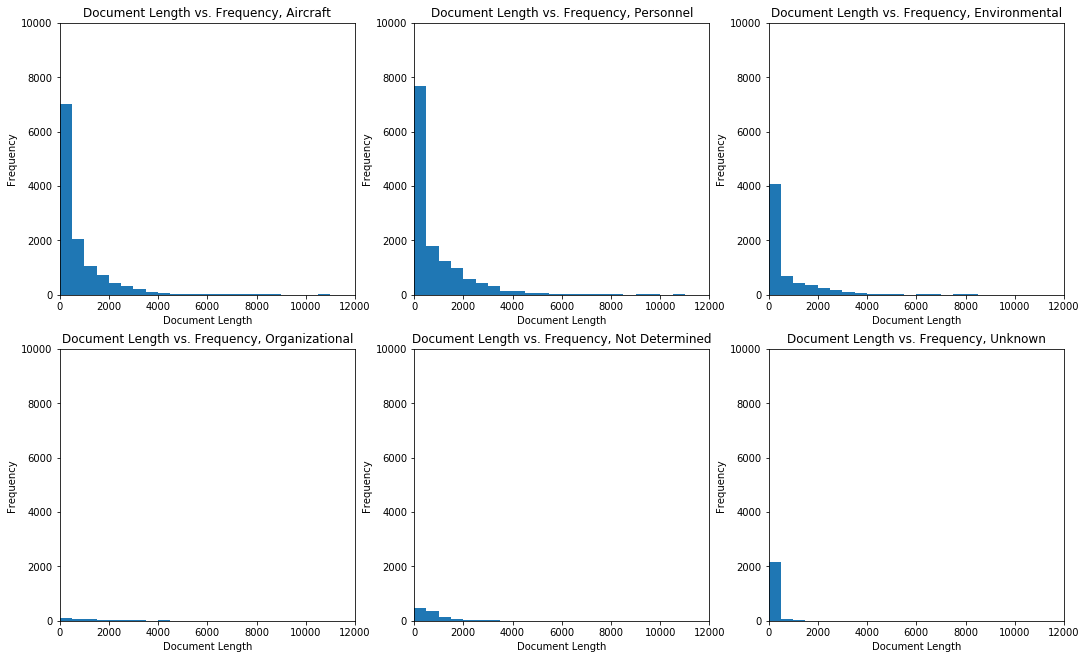

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [18,11]

plt.subplot(231)
plt.hist(counts_list[0], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Aircraft')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))

plt.subplot(232)
plt.hist(counts_list[1], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Personnel')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))

plt.subplot(233)
plt.hist(counts_list[2], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Environmental')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))

plt.subplot(234)
plt.hist(counts_list[3], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Organizational')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))

plt.subplot(235)
plt.hist(counts_list[4], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Not Determined')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))

plt.subplot(236)
plt.hist(counts_list[5], bins=list(np.arange(0,12000,500)))
plt.title('Document Length vs. Frequency, Unknown')
plt.xlabel("Document Length")
plt.ylabel("Frequency")
plt.axis((0,12000,0,10000))
plt.show()

The top three distributions (aircraft, personel, environmental) are similar while the bottom three (Organizational, not determined, Unknown) have less observations and the distributions are less meaningful.

#### Visualizing meaningful words
1. With bigrams
2. No bigrams

started timing


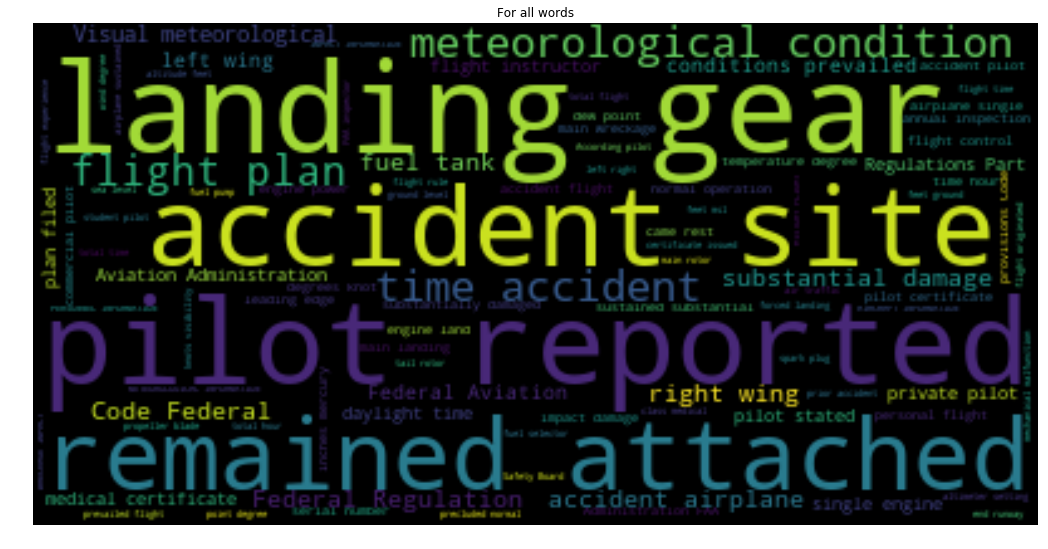

stopped timing after 97.33secs


In [31]:
mytiming.tic()

# create word cloud for 'narr_cause' for different damage types
item =df['narr_accp'].dropna().tolist()
wc = WordCloud().generate(' '.join(item))
plt.figure()
plt.title('For all words')
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show() 

mytiming.toc()

started timing


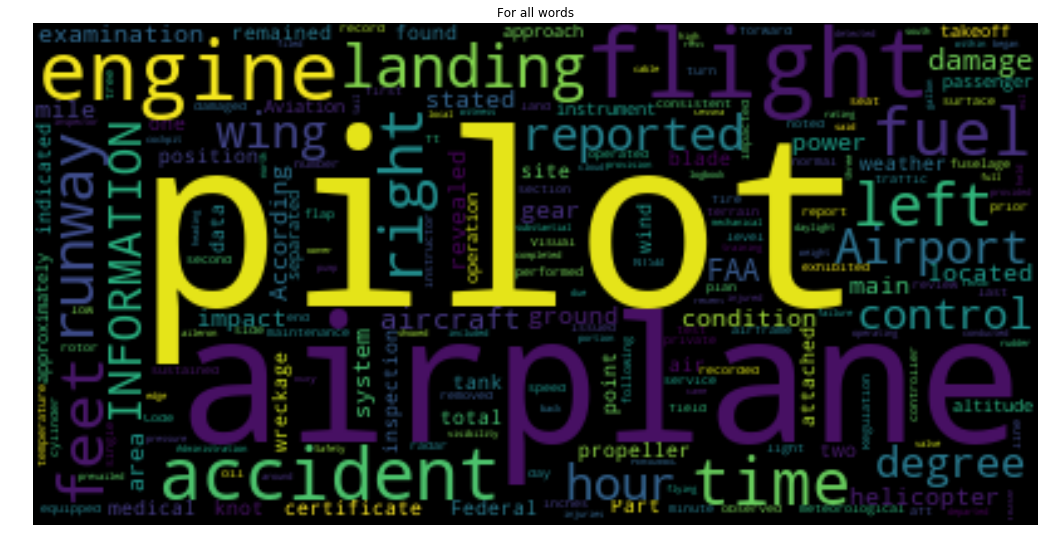

stopped timing after 57.68secs


In [32]:
mytiming.tic()

# create word cloud for 'narr_cause' for different damage types
item =df['narr_accp'].dropna().tolist()
wc = WordCloud(collocations=False).generate(' '.join(item))
plt.figure()
plt.title('For all words')
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show() 

mytiming.toc()

This wordcloud shows most popular words first with bigrams then without. 

#### Bigrams
Landing gear must cause alot of issues. The preliminary reports appear to recieve alot of information from the the pilot, and lastly luckily most things 'remained attached'.
#### No bigrams
Pilot, airplane, and flight are all biggest words this is obvious because our documents are from flight events. It will be interesting to see how the wordclouds look for each class.

#### Investigation of Words In prelim report by class
* max_df, min_df, and stop_words selction remains conisent as previously seleceted

started timing


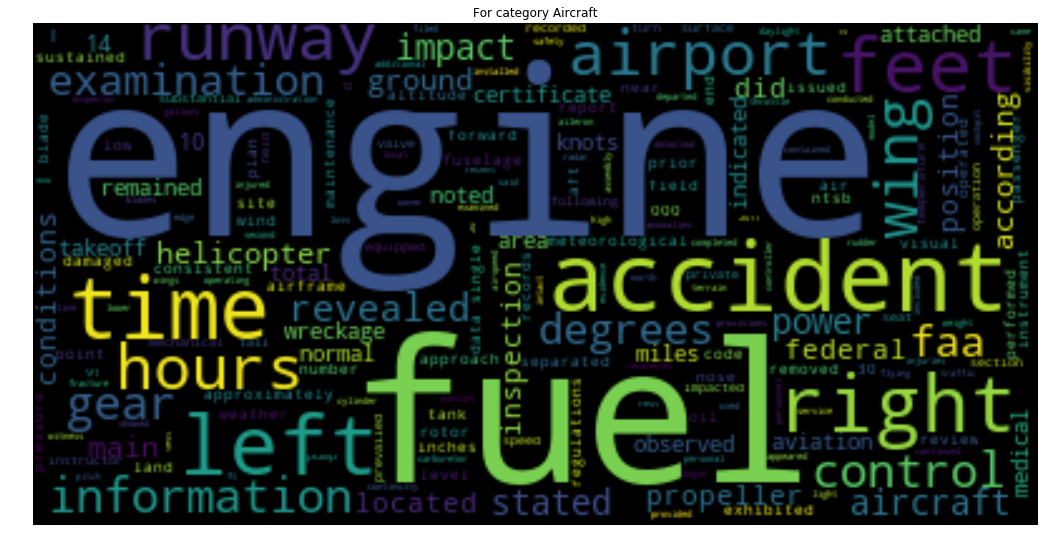

engine      71077
fuel        47706
accident    46660
time        35751
left        34200
right       30935
feet        29397
runway      28507
airport     25311
hours       25079
dtype: int64


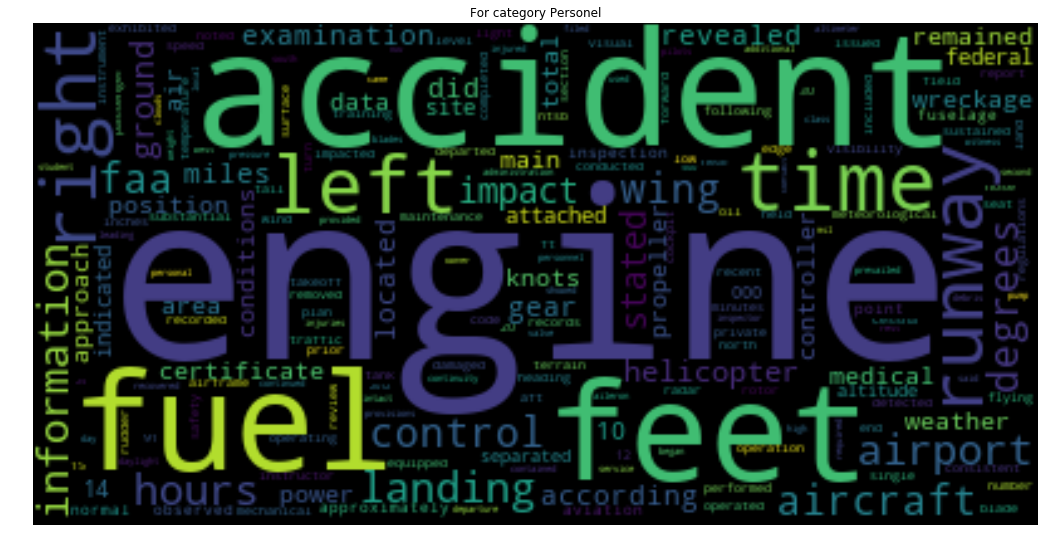

engine      69934
accident    63061
feet        45957
fuel        45946
time        45416
left        41156
runway      39370
right       38075
landing     34772
airport     34128
dtype: int64


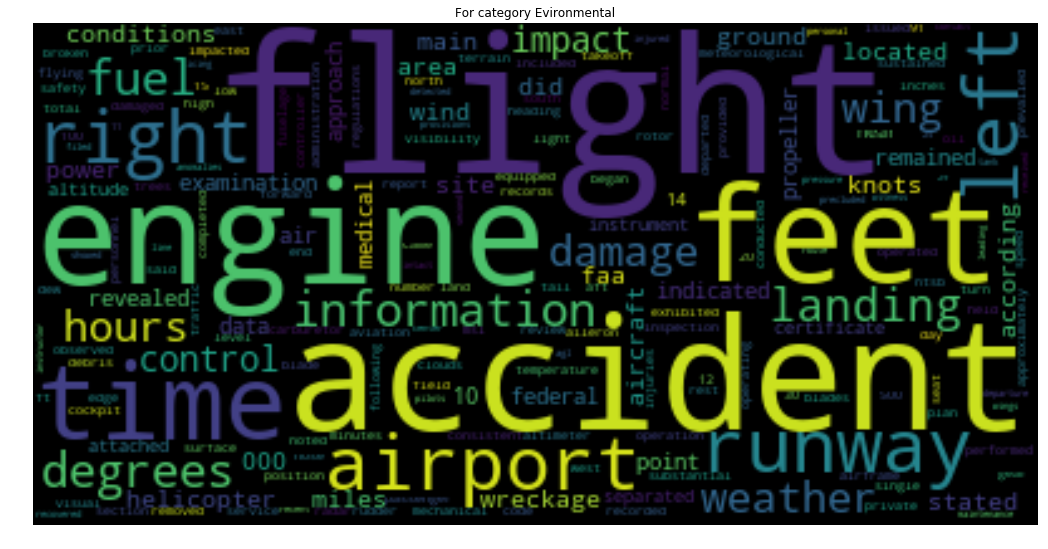

flight         39934
accident       26542
engine         25450
feet           22195
time           17943
airport        14490
left           14165
runway         14125
right          13472
information    12801
dtype: int64


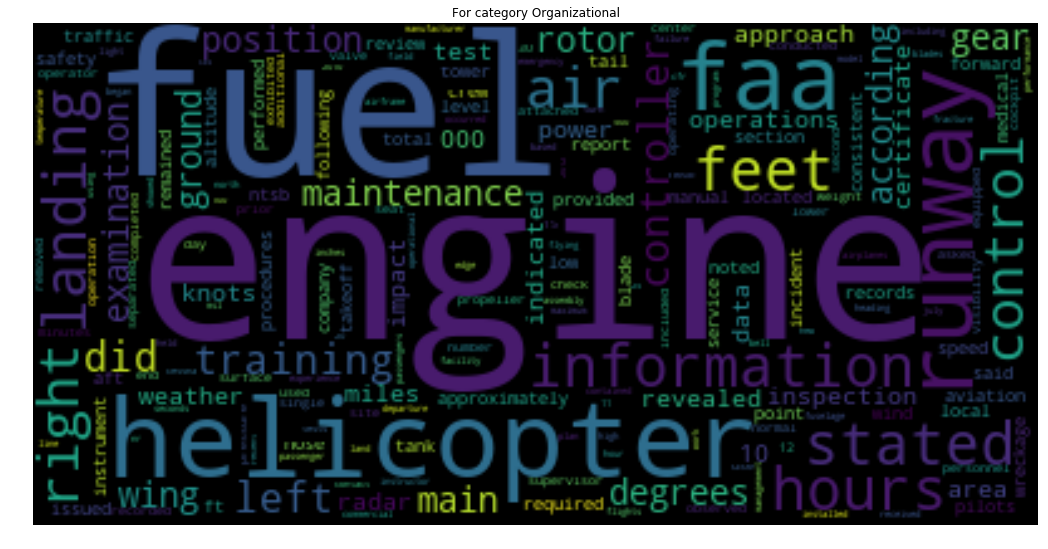

engine         3672
fuel           2913
helicopter     2889
faa            2113
runway         2106
information    2074
stated         2031
feet           2004
hours          1997
landing        1953
dtype: int64


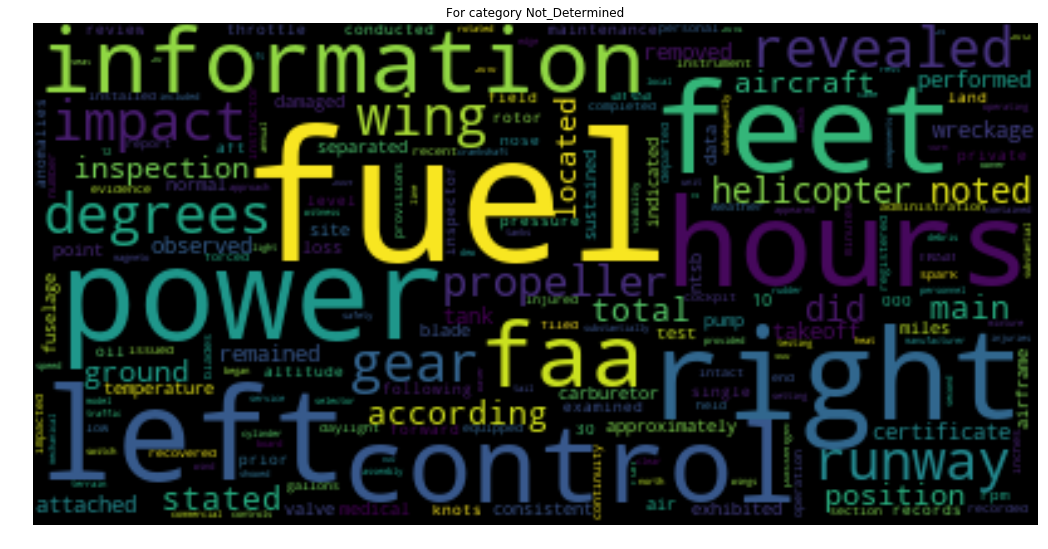

fuel           7526
power          3247
left           3218
right          3046
feet           3035
hours          2941
control        2644
information    2462
faa            2448
degrees        2342
dtype: int64


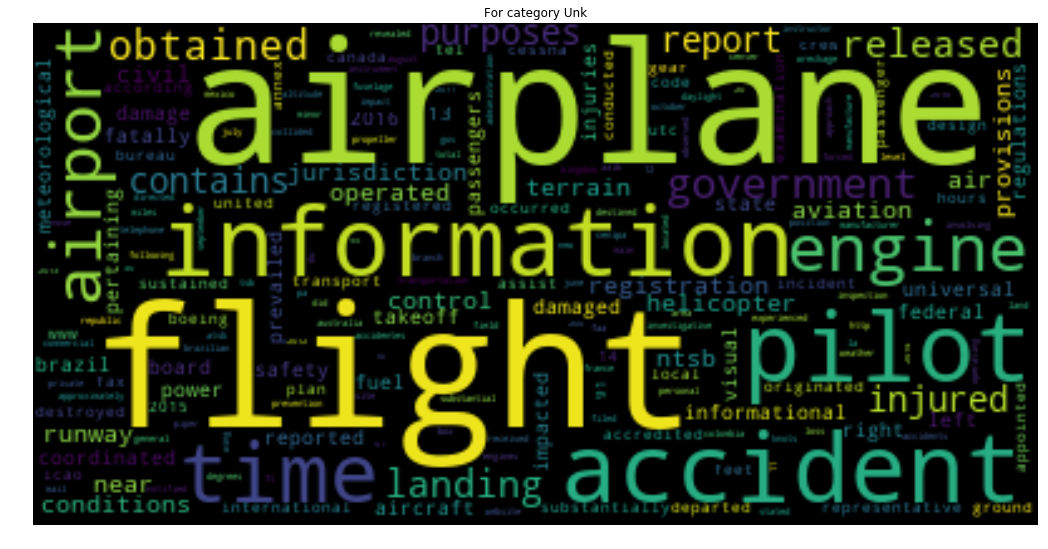

airplane       4123
flight         4066
information    3336
accident       3254
pilot          3232
time           2359
engine         2176
airport        2122
government     1987
obtained       1775
dtype: int64
stopped timing after 54.13secs


In [33]:
mytiming.tic()

# create word clounds after limiting data with max_df & min_df. Also stop_words='english'
for category in df['category_no'].unique():
    if category != None:
        # create bag of words
        count_vect = CountVectorizer(max_df=.75,min_df=.01, stop_words='english')
        bag_words = count_vect.fit_transform(df['narr_accp'][df['category_no']==category].dropna().tolist())
        # create pandas df of the words
        df_words = pd.DataFrame(data=bag_words.toarray(),columns=count_vect.get_feature_names())
        # create word cloud after reducing vocab
        wc = WordCloud().generate_from_frequencies(df_words.sum())
        plt.figure()
        plt.title('For category ' + category)
        plt.imshow(wc,interpolation="bilinear")
        plt.axis("off")
        plt.show()
        print(df_words.sum().sort_values()[-10:].sort_values(ascending=False))
        
mytiming.toc()

Even after removing words it appears as if the word clouds are similar for each category. Interesting to see that the unknown findings category has the word goverment as well as obtained in the top 10.Helicopter only shows up in the top 10 for orginizational. Helicopter also was in the top 10 for tfidf. Helicopter should be a good classifier of orginzational. 

Wordcloud no longer looks at bigrams as compared to when fed text in the word cloud that emcompessed all words.

Engine appears to be a large indicator of aircraft and personel (we know the same prelim report can have multiple categories). Many words such as accident are popular for each class. The word cloud is a visulization that shows that tuning our max_df and min_df parameters will be important. Lastly, because the word cloud that included bigrams has differnt results for the most popular words bigrams may prove important.

# Exceptional Work

### Bigram Distributions

In [34]:
import nltk
from nltk.corpus import stopwords
import string
from nltk.collections import *
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# stop words with string punctuation
stop = set(stopwords.words('english'))
all_stops = stop | set(string.punctuation)

##### Bigram Distribution based on Category Codes
Bigram is a sequence of two elements that occur together and the frequency the two element occur. The graphs show frequency distribution of the top 20 bigrams based on Category Codes. Stop words, such as 'the' or 'on', have been removed prior to calculating the frequencies for bigrams. 

started timing


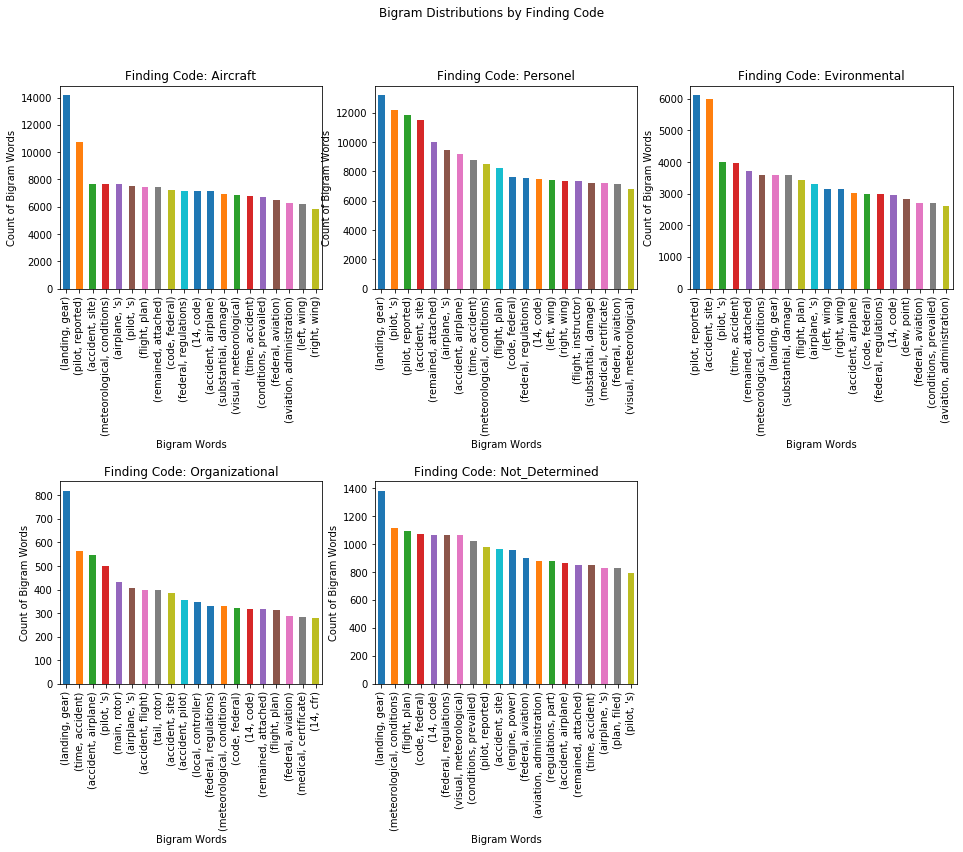

stopped timing after 450.85secs


In [36]:
# build plot
f, my_axes = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 11))

# axes is list of lists, so unroll into a single list a <- b <- axes
axes_list = [a for b in my_axes for a in b]
mytiming.tic()
mygraphs = []

# Graph for Each Category Code
for code, my_ax in zip(df['category_no'].unique(), axes_list):
    if code != 'Unk':
        category_text = df['narr_accp'][df['category_no'] == code].dropna().tolist()

        # combine all documents into one string value
        category_text_string = ' '.join(category_text).lower()

        # tokenize finding text string
        tokens = nltk.word_tokenize(category_text_string)

        # ignore all stop words
        no_stopPunc = [text for text in tokens if text not in all_stops]

        # bigram distribution
        bigram = nltk.bigrams(no_stopPunc)

        # frequency distribution
        fdist = nltk.FreqDist(bigram)

        # convert frequency distribution into dataframe
        bg_df = pd.DataFrame.from_dict(fdist, orient = 'index')

        # reset index to create bar chart
        new_bgdf = bg_df.reset_index().sort_values(by = 0, ascending = False).reset_index(drop = True)

        # plot bigram distribution
        gi = new_bgdf[:20].plot(x = 'index', y = 0, kind = 'bar', legend = False, ax=my_ax)
        gi.set_title('Finding Code: ' + str(code))
        gi.set_ylabel('Count of Bigram Words')
        gi.set_xlabel('Bigram Words')
        mygraphs.append(gi)
axes_list[-1].set_visible(False)
plt.suptitle('Bigram Distributions by Finding Code')
plt.subplots_adjust(hspace = .95)
plt.show()

mytiming.toc()

### Observations from Bigram Plots

**Landing Gear** has the highest frequency for all categories except for the *Environmental Issues* category. Each document can be assigned multiple categories which could lead to bigrams occuring at the same frequencies. 

**Accident Site** and **Pilot Reported** have the largest frequency for *Environmental Issues* category with all other bigram occuring at a realtively lower frequency.

*Personnel Issues* bigram plot does not show a significant difference between bigram words. Which may provide evidence to suggest that there are more factors involved for a specific event to be classifed as a Personnel Issue. *Not Determined* shows the top 20 bigrams having realtively equal frequencies, with the exception of **Landing Gear**. 



### Stemming
#### Investigation of Words In prelim report by class after stemming
* word clouds are shown as well as top 10 word frequency
* max_df, min_df, and stop_words selction remains conisent as previously seleceted

started timing


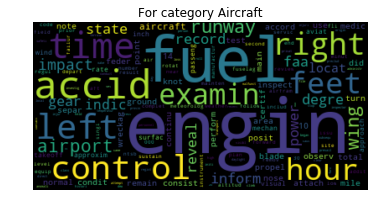

engin      75633
fuel       49024
accid      47412
time       38367
left       34200
control    32893
right      31003
hour       29632
feet       29397
examin     29241
dtype: int64


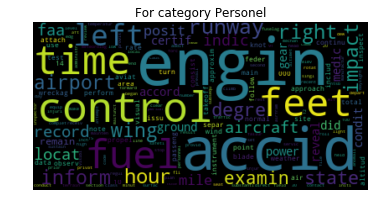

engin      74635
accid      63960
control    52693
time       48712
fuel       47479
feet       45957
left       41156
runway     40675
right      38134
hour       36654
dtype: int64


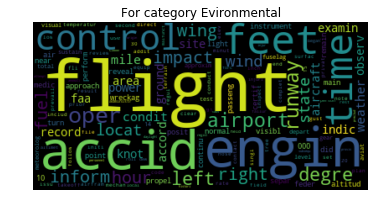

flight     41071
engin      26968
accid      26822
feet       22195
time       19042
control    16795
oper       14905
airport    14880
runway     14477
degre      14460
dtype: int64


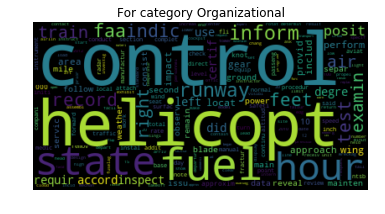

control     4250
helicopt    3185
fuel        3019
state       2610
hour        2417
runway      2281
inform      2226
faa         2113
record      2016
test        2006
dtype: int64


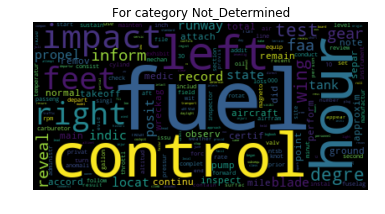

fuel       7705
control    3798
hour       3424
left       3218
impact     3053
right      3052
feet       3035
degre      2666
wing       2664
test       2589
dtype: int64


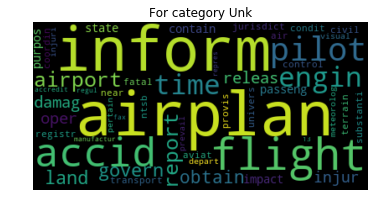

airplan    4269
inform     4172
flight     4119
accid      3531
pilot      3443
engin      2417
time       2410
airport    2127
report     2125
govern     1989
dtype: int64
stopped timing after 485.0secs


In [37]:
mytiming.tic()

# stemming #
stemmer = SnowballStemmer('english')
analyzer = CountVectorizer(stop_words = 'english', max_df=.75, min_df=.01).build_analyzer()

# fuunction found for returning words
def stemmed_words(doc):
    return(stemmer.stem(w) for w in analyzer(doc))
    
for category in df['category_no'].unique():
    if category != None:
        stem_vectorizer = CountVectorizer(analyzer = stemmed_words, max_df=.75, min_df=.25, stop_words='english')
        stem_bag_words = stem_vectorizer.fit_transform(df['narr_accp'][df['category_no']==category].dropna().tolist())
        # Puts bag of words into a pandas dataframe
        stem_count = pd.DataFrame(data = stem_bag_words.toarray(), columns = stem_vectorizer.get_feature_names())
        # create word cloud after reducing vocab
        wc = WordCloud().generate_from_frequencies(stem_count.sum())
        plt.figure()
        plt.title('For category ' + category)
        plt.imshow(wc,interpolation="bilinear")
        plt.axis("off")
        plt.show()
        print(stem_count.sum().sort_values()[-10:].sort_values(ascending=False))
        
mytiming.toc()

Stemmed word clouds are slightly different from not stemmed word clouds. Interesting that control now is in top 10 for some categories. Also, the word runway now appears. FAA and State now only appear in orgizational this makes sense and should help classify orginizational findings.
Hoping to see some unique words in enviromental. Possible after we optimimze max_df and min_df the eviromental category will have unique words.